In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

# Cargar el archivo CSV para examinar su contenido
sp500 = pd.read_csv("./src/data/sp500_historico.csv")

sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6280 entries, 0 to 6279
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      6280 non-null   object
 1   Adj Close  6279 non-null   object
 2   Close      6279 non-null   object
 3   High       6279 non-null   object
 4   Low        6279 non-null   object
 5   Open       6279 non-null   object
 6   Volume     6279 non-null   object
dtypes: object(7)
memory usage: 343.6+ KB


In [5]:
# Renombrar columna
sp500.rename(columns={'Price': 'Date'},inplace=True)

In [6]:
# Eliminar filas y columnas con informacion erronea
sp500.drop([0,1], inplace=True)
sp500.drop(columns=['Adj Close'], inplace=True)

In [7]:
# Cambiar columna Date para manejar fechas
sp500['Date'] = pd.to_datetime(sp500['Date'], format='%Y-%m-%d')
print(sp500['Date'].dtype)

datetime64[ns]


In [8]:
# Mostrar modificacion
sp500.head()

,Date,Close,High,Low,Open,Volume
2,2000-01-03,1455.219970703125,1478.0,1438.3599853515625,1469.25,931800000
3,2000-01-04,1399.4200439453125,1455.219970703125,1397.4300537109375,1455.219970703125,1009000000
4,2000-01-05,1402.1099853515625,1413.27001953125,1377.6800537109375,1399.4200439453125,1085500000
5,2000-01-06,1403.449951171875,1411.9000244140625,1392.0999755859375,1402.1099853515625,1092300000
6,2000-01-07,1441.469970703125,1441.469970703125,1400.72998046875,1403.449951171875,1225200000


In [9]:
# Corroborar si existen valores nulos
sp500.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [10]:
# Verificar tipo de datos para su tratamiento 
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6278 entries, 2 to 6279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6278 non-null   datetime64[ns]
 1   Close   6278 non-null   object        
 2   High    6278 non-null   object        
 3   Low     6278 non-null   object        
 4   Open    6278 non-null   object        
 5   Volume  6278 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 294.4+ KB


In [11]:
# Modificar tipo de datos de Objeto a Numericos
sp500[['Close', 'High', 'Low', 'Open', 'Volume']] = sp500[['Close', 'High', 'Low', 'Open', 'Volume']].apply(pd.to_numeric)

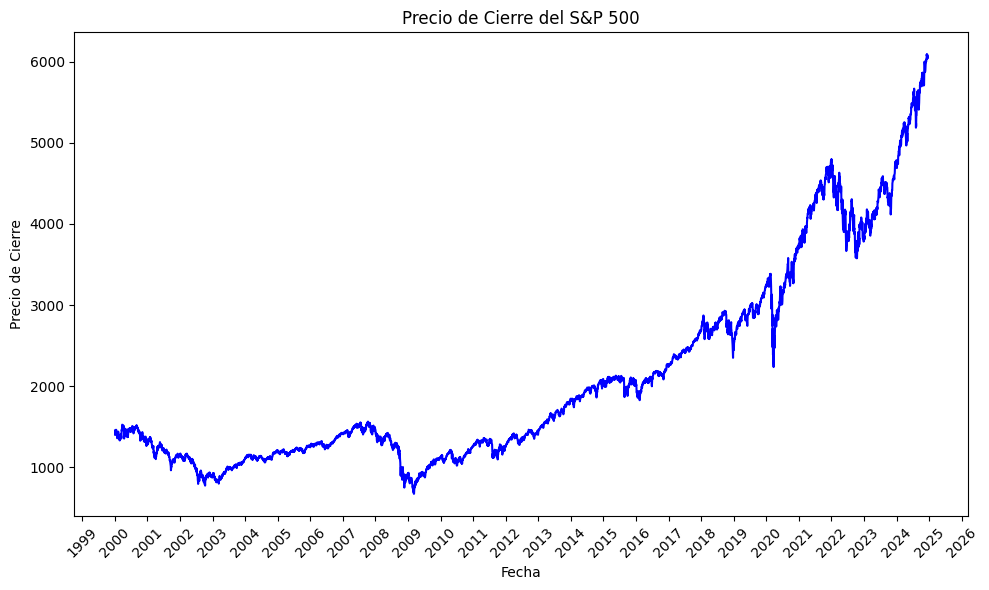

In [12]:
# Graficar el precio de cierre
plt.figure(figsize=(10, 6))
plt.plot(sp500['Date'], sp500['Close'], label='Precio de Cierre', color='blue')

# Título y etiquetas de los ejes
plt.title('Precio de Cierre del S&P 500')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')

# Formato de la fecha y el intervalo de las etiquetas en el eje x
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Muestra una etiqueta por cada año
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Muestra el año

# Ajustar el layout
plt.tight_layout()
plt.grid(False)

# Mostrar la gráfica
plt.show()

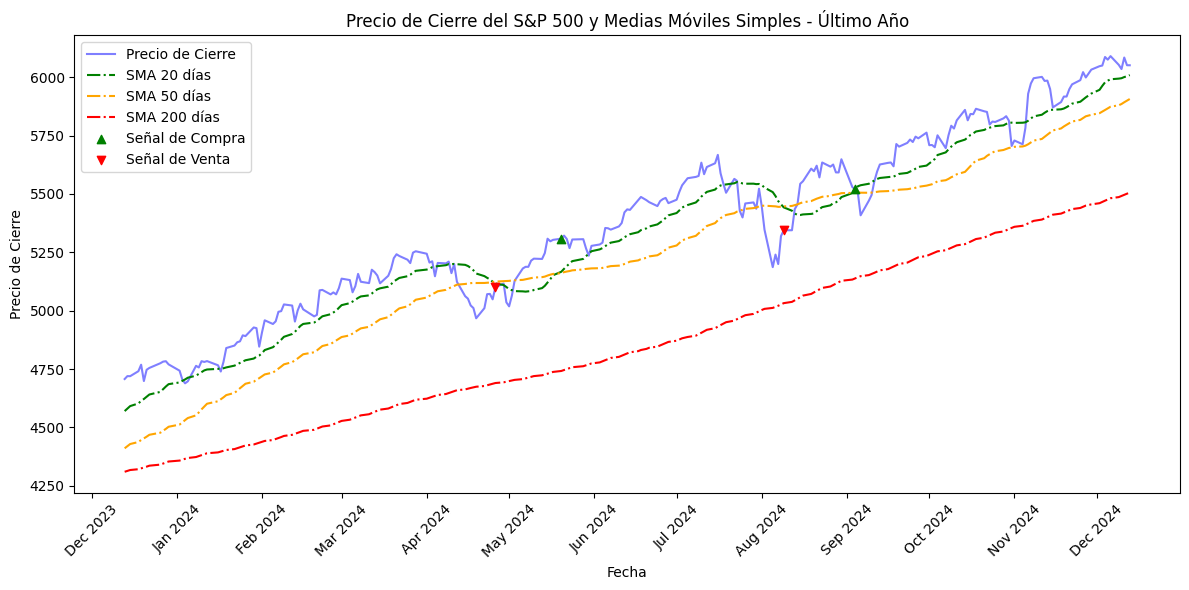

In [13]:
# 1. Calcular Medias Móviles Simples (SMA)
sp500['SMA_20'] = sp500['Close'].rolling(window=20).mean()  # Media móvil de 20 días
sp500['SMA_50'] = sp500['Close'].rolling(window=50).mean()  # Media móvil de 50 días
sp500['SMA_200'] = sp500['Close'].rolling(window=200).mean()  # Media móvil de 200 días

# 2. Identificar señales de Compra y Venta basadas en SMA_20 y SMA_50
sp500['Signal'] = 0
sp500.loc[sp500['SMA_20'] > sp500['SMA_50'], 'Signal'] = 1  # Compra cuando SMA_20 > SMA_50
sp500.loc[sp500['SMA_20'] < sp500['SMA_50'], 'Signal'] = -1  # Venta cuando SMA_20 < SMA_50

# Filtrar señales de Compra y Venta
buy_signals = sp500[(sp500['Signal'] == 1) & (sp500['Signal'].shift(1) != 1)]
sell_signals = sp500[(sp500['Signal'] == -1) & (sp500['Signal'].shift(1) != -1)]

# 3. Filtrar datos del último año
ultimo_anio = sp500[sp500['Date'] >= (sp500['Date'].max() - pd.DateOffset(years=1))]

# Filtrar señales del último año
buy_signals_anio = buy_signals[buy_signals['Date'] >= (sp500['Date'].max() - pd.DateOffset(years=1))]
sell_signals_anio = sell_signals[sell_signals['Date'] >= (sp500['Date'].max() - pd.DateOffset(years=1))]

# 4. Graficar el Precio de Cierre, SMAs y Señales del último año
plt.figure(figsize=(12, 6))

# Precio de cierre
plt.plot(ultimo_anio['Date'], ultimo_anio['Close'], label='Precio de Cierre', color='blue', alpha=0.5)

# Medias móviles simples
plt.plot(ultimo_anio['Date'], ultimo_anio['SMA_20'], label='SMA 20 días', color='green', linestyle='-.')
plt.plot(ultimo_anio['Date'], ultimo_anio['SMA_50'], label='SMA 50 días', color='orange', linestyle='-.')
plt.plot(ultimo_anio['Date'], ultimo_anio['SMA_200'], label='SMA 200 días', color='red', linestyle='-.')

# Señales de Compra y Venta
plt.scatter(buy_signals_anio['Date'], buy_signals_anio['Close'], marker='^', color='green', label='Señal de Compra', zorder=5)
plt.scatter(sell_signals_anio['Date'], sell_signals_anio['Close'], marker='v', color='red', label='Señal de Venta', zorder=5)

# 5. Añadir títulos y etiquetas
plt.title('Precio de Cierre del S&P 500 y Medias Móviles Simples - Último Año')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Etiqueta por cada mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato: Mes y Año

# 6. Mostrar leyenda y gráfica
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

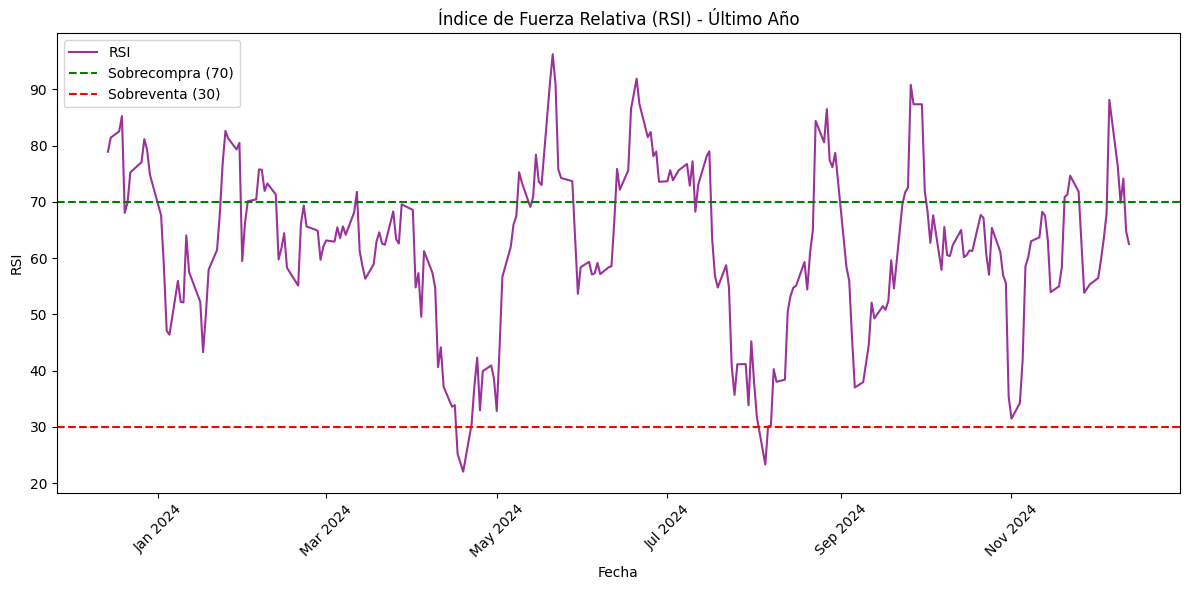

In [14]:
# Parámetro del RSI
n = 14  # Período estándar del RSI

# 1. Calcular los cambios diarios
sp500['Change'] = sp500['Close'].diff()

# 2. Calcular ganancias y pérdidas
sp500['Gain'] = sp500['Change'].apply(lambda x: x if x > 0 else 0)
sp500['Loss'] = sp500['Change'].apply(lambda x: -x if x < 0 else 0)

# 3. Calcular la media móvil de ganancias y pérdidas (EMA)
sp500['Avg_Gain'] = sp500['Gain'].rolling(window=n, min_periods=1).mean()
sp500['Avg_Loss'] = sp500['Loss'].rolling(window=n, min_periods=1).mean()

# 4. Calcular el RSI
sp500['RS'] = sp500['Avg_Gain'] / sp500['Avg_Loss']
sp500['RSI'] = 100 - (100 / (1 + sp500['RS']))

# 5. Filtrar datos para el último año
ultimo_anio = sp500[sp500['Date'] >= (sp500['Date'].max() - pd.Timedelta(days=365))]

# 6. Graficar el RSI del último año
plt.figure(figsize=(12, 6))
plt.plot(ultimo_anio['Date'], ultimo_anio['RSI'], label='RSI', color='purple', alpha=0.8)

# Líneas de referencia para sobrecompra y sobreventa
plt.axhline(70, color='green', linestyle='--', label='Sobrecompra (70)')
plt.axhline(30, color='red', linestyle='--', label='Sobreventa (30)')

# Añadir títulos y etiquetas
plt.title('Índice de Fuerza Relativa (RSI) - Último Año')
plt.xlabel('Fecha')
plt.ylabel('RSI')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato de fecha

# Mostrar leyenda y la gráfica
plt.legend(loc='best')
plt.tight_layout()
plt.show()

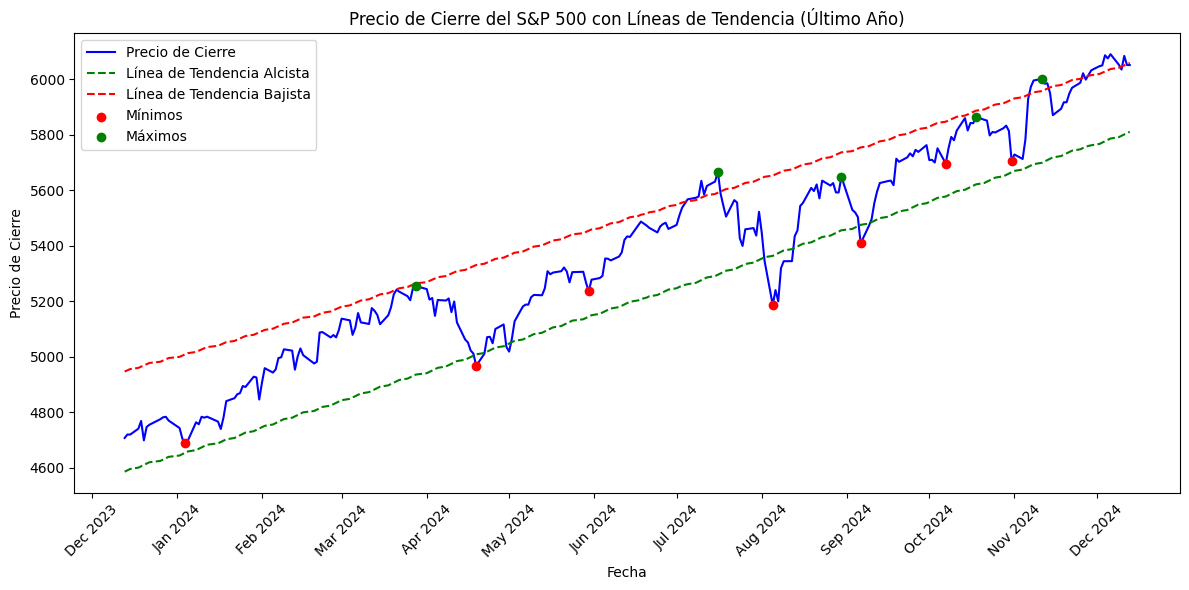

In [15]:
# 1. Filtrar datos del último año
ultimo_anio = sp500[sp500['Date'] >= sp500['Date'].max() - pd.DateOffset(years=1)]

# 2. Encontrar mínimos y máximos locales manualmente
def encontrar_extremos(data, window=10):
    minimos = []
    maximos = []
    
    for i in range(window, len(data) - window):
        ventana = data[i - window:i + window + 1]
        if data[i] == min(ventana):
            minimos.append(i)
        if data[i] == max(ventana):
            maximos.append(i)
    
    return minimos, maximos

# 3. Aplicar la función para encontrar extremos
window_size = 10  # Tamaño de la ventana para determinar extremos
minimos, maximos = encontrar_extremos(ultimo_anio['Close'].values, window=window_size)

# Extraer los puntos mínimos y máximos
x_min = minimos
y_min = ultimo_anio['Close'].iloc[minimos]
x_max = maximos
y_max = ultimo_anio['Close'].iloc[maximos]

# 4. Calcular líneas de tendencia
# Alcista: Ajuste a los mínimos
p_ascendente = np.polyfit(x_min, y_min, 1)
linea_ascendente = np.polyval(p_ascendente, range(len(ultimo_anio)))

# Bajista: Ajuste a los máximos
p_descendente = np.polyfit(x_max, y_max, 1)
linea_descendente = np.polyval(p_descendente, range(len(ultimo_anio)))

# 5. Graficar el precio de cierre del último año
plt.figure(figsize=(12, 6))
plt.plot(ultimo_anio['Date'], ultimo_anio['Close'], label='Precio de Cierre', color='blue')

# 6. Graficar las líneas de tendencia
plt.plot(ultimo_anio['Date'], linea_ascendente, label='Línea de Tendencia Alcista', linestyle='--', color='green')
plt.plot(ultimo_anio['Date'], linea_descendente, label='Línea de Tendencia Bajista', linestyle='--', color='red')

# 7. Marcar los puntos mínimos y máximos
plt.scatter(ultimo_anio['Date'].iloc[minimos], y_min, color='red', label='Mínimos', zorder=5)
plt.scatter(ultimo_anio['Date'].iloc[maximos], y_max, color='green', label='Máximos', zorder=5)

# 8. Añadir títulos y etiquetas
plt.title('Precio de Cierre del S&P 500 con Líneas de Tendencia (Último Año)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Muestra una etiqueta por cada mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Muestra mes y año

# 9. Mostrar leyenda
plt.legend()
plt.grid(False)

# 10. Mostrar la gráfica
plt.tight_layout()
plt.show()

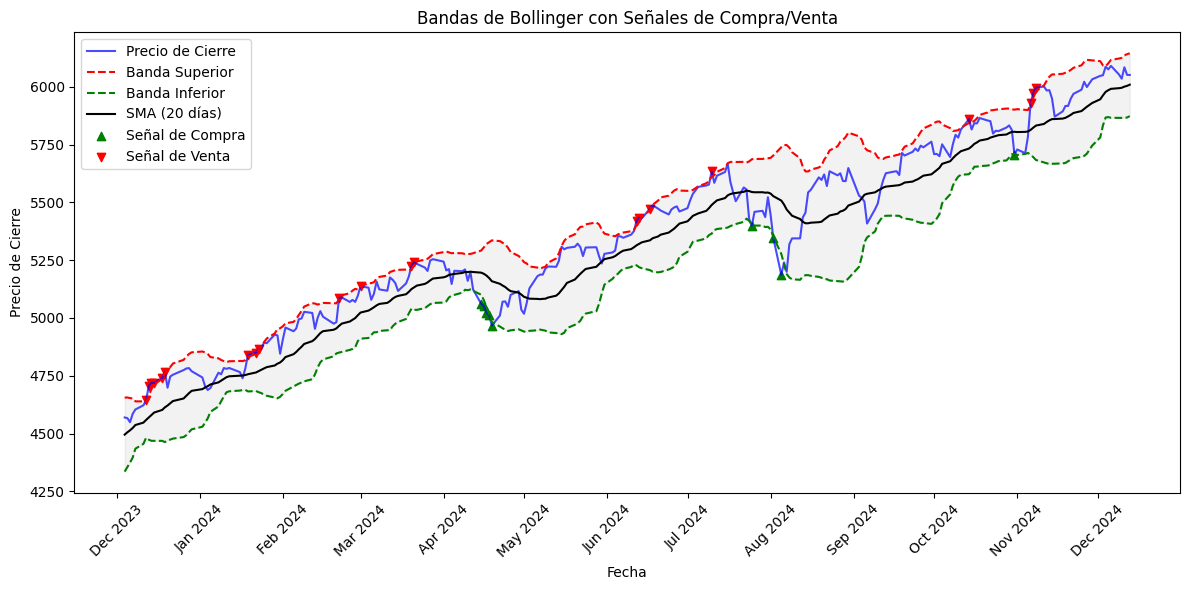

In [16]:
# 1. Parámetros para las Bandas de Bollinger
n = 20  # Período de la SMA
k = 2   # Número de desviaciones estándar

# 2. Calcular la SMA (Media Móvil Simple)
sp500['SMA'] = sp500['Close'].rolling(window=n).mean()

# 3. Calcular la Desviación Estándar
sp500['STD'] = sp500['Close'].rolling(window=n).std()

# 4. Calcular las Bandas Superior e Inferior
sp500['Banda Superior'] = sp500['SMA'] + (k * sp500['STD'])
sp500['Banda Inferior'] = sp500['SMA'] - (k * sp500['STD'])

# 5. Generar Señales de Compra y Venta
sp500['Compra'] = sp500['Close'] < sp500['Banda Inferior']  # Señal de compra
sp500['Venta'] = sp500['Close'] > sp500['Banda Superior']  # Señal de venta

# Filtrar datos recientes para una mejor visualización (ejemplo: últimos 100 días)
recientes = sp500.tail(260)

# 6. Graficar el Precio de Cierre, Bandas de Bollinger y Señales
plt.figure(figsize=(12, 6))

# Precio de cierre
plt.plot(recientes['Date'], recientes['Close'], label='Precio de Cierre', color='blue', alpha=0.7)

# Bandas de Bollinger
plt.plot(recientes['Date'], recientes['Banda Superior'], label='Banda Superior', color='red', linestyle='--')
plt.plot(recientes['Date'], recientes['Banda Inferior'], label='Banda Inferior', color='green', linestyle='--')
plt.plot(recientes['Date'], recientes['SMA'], label='SMA (20 días)', color='black', linestyle='-')

# Rellenar entre las bandas
plt.fill_between(recientes['Date'], recientes['Banda Superior'], recientes['Banda Inferior'], color='gray', alpha=0.1)

# Señales de Compra y Venta
plt.scatter(recientes['Date'][recientes['Compra']], recientes['Close'][recientes['Compra']], 
            label='Señal de Compra', color='green', marker='^', alpha=1)
plt.scatter(recientes['Date'][recientes['Venta']], recientes['Close'][recientes['Venta']], 
            label='Señal de Venta', color='red', marker='v', alpha=1)

# Añadir títulos y etiquetas
plt.title('Bandas de Bollinger con Señales de Compra/Venta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Muestra una etiqueta por cada mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Muestra mes y año

# Mostrar leyenda
plt.legend()
plt.grid(False)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

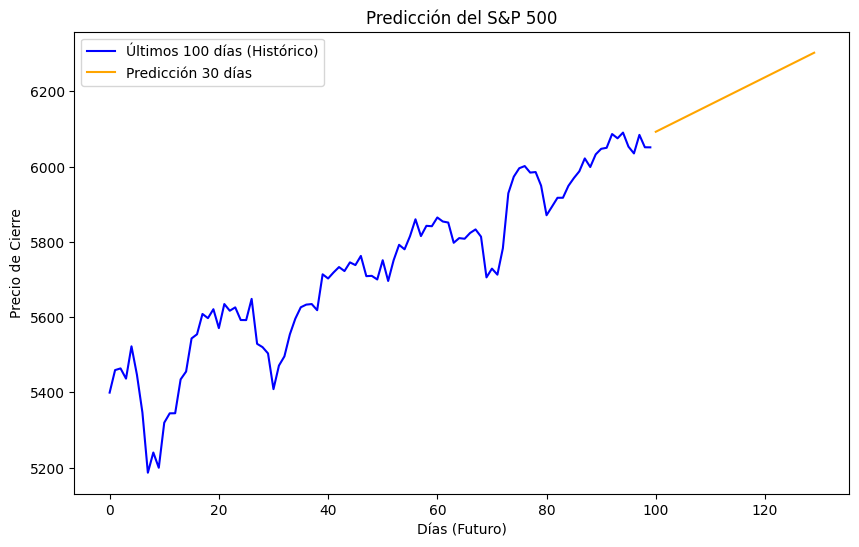

In [24]:
sp500_last_year = sp500.tail(100).copy()

# Asegurarnos de que la columna de días esté presente
sp500_last_year['Days'] = range(len(sp500_last_year))

# Ahora, podemos proceder a usar la regresión lineal
X = sp500_last_year['Days'].values.reshape(-1, 1)
y = sp500_last_year['Close'].values

# Entrenamiento del modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Coeficientes
m = model.coef_[0]
b = model.intercept_


# Predicción para 30 
last_day = sp500_last_year['Days'].iloc[-1]
future_days = np.array([last_day + i for i in range(1, 91)]).reshape(-1, 1)
future_predictions = model.predict(future_days)

# Graficar datos históricos del último año
plt.figure(figsize=(10, 6))
plt.plot(sp500_last_year['Days'], sp500_last_year['Close'], label='Últimos 100 días (Histórico)', color='blue')

# Graficar las predicciones
plt.plot(future_days[:30], future_predictions[:30], label='Predicción 30 días', color='orange', linestyle='-')

# Etiquetas y leyenda
plt.title('Predicción del S&P 500')
plt.xlabel('Días (Futuro)')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(False)
plt.show()